In [7]:
__depends__=[]
__dest__="../results/f8.eps"

# Plot Terms in the Two-fluid EBTEL Equations
As part of our derivation of the two-fluid EBTEL equations, we'll plot the different terms of the two-fluid electron energy equation,
$$
\frac{L}{\gamma - 1}\frac{dp_e}{dt} = \psi_{TR} - (\mathcal{R}_C + \mathcal{R}_{TR}) + \frac{L}{\gamma - 1}k_Bn\nu_{ei}(T_i - T_e) + LQ_e.
$$
We want to plot each term as a function of time to show their relative contributions to the evolution of the electron energy.

In [8]:
import sys
import os

import numpy as np
import seaborn.apionly as sns
import astropy.constants as const
from matplotlib import ticker
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['EXP_DIR'],'EBTEL_analysis/src/'))
import ebtel_run as ebr
import ebtel_configure as ebc

%matplotlib inline

In [9]:
plt.rcParams.update({'figure.figsize' : [8,5]})

Configure the EBTEL run. We'll use $\tau=200$ s and $H_0=0.1$ erg cm$^{-3}$ s$^{-1}$, $L=40$ Mm, and Spitzer conduction.

In [10]:
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.1
config_dict['rka_error'] = 1.0e-5
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.5e-5
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['sample_rate'] = 1
#variable c1 options
config_dict['r3_rad_0'] = 0.6
config_dict['r3_cond_0'] = 6.0
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_grav_correction'] = 'True'
config_dict['output_file'] = '../results/__tmp__'

In [11]:
configurer = ebc.Configurer(config_dict,'')
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')

Run the model.

In [12]:
runner = ebr.Runner(os.path.join(os.environ['EXP_DIR'],'EBTEL-2fluid_repo/bin/'),'')
runner.run_ebtel_single(config_dict['output_file']+'.xml')

Load the data.

In [13]:
data = np.loadtxt(config_dict['output_file']+'.txt')
t = data[:,0]
Te = data[:,1]
Ti = data[:,2]
n = data[:,3]
fce = data[:,12]
fci = data[:,13]
q = data[:,15]
rad = data[:,-2]
r3 = data[:,-3]

Define a function to calculate the Coulomb collision frequency according to [Braginskii (1965)](http://adsabs.harvard.edu/abs/1965RvPP....1..205B).

In [14]:
def calc_nu_ei(n,Te):
    c1 = 16.*np.sqrt(np.pi)/3.
    c2 = const.e.gauss.value**4/(const.m_e.cgs.value*const.m_p.cgs.value)
    c3 = 2.*const.k_B.cgs.value*Te/const.m_e.cgs.value
    colLog = 20.
    return c1*c2*c3**(-3./2.)*n*colLog

Calculate the terms as given in the equation above.

In [15]:
delta_terms = []
delta_terms.append(fce/(config_dict['loop_length']*1.e+8)/(1.+Te/Ti))
delta_terms.append(-fci/(config_dict['loop_length']*1.e+8)*(Te/Ti)/(1.+Te/Ti))
delta_terms.append(-(Te/Ti*(r3+1.) + 1.)/(1.+Te/Ti)*n**2*rad)
#delta_terms.append(q)
tmp = np.zeros(len(Te))
for i in range(len(Te)):
    tmp[i] = const.k_B.cgs.value/(5./3. - 1.)*n[i]*calc_nu_ei(n[i],Te[i])*(Ti[i] - Te[i])
delta_terms.append(tmp)

Make the figure.

In [16]:
labels = [r'$\mathrm{e}^{-}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{ion}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{radiation}$',r'$\mathrm{equilibration}$']

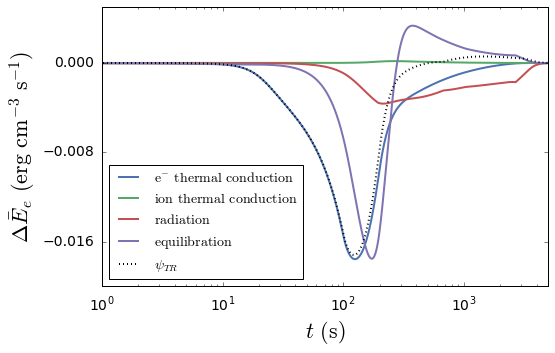

In [17]:
fig = plt.figure()
ax = fig.gca()
for i in range(len(delta_terms)):
        ax.plot(t,delta_terms[i],color=sns.color_palette('deep')[i],label=labels[i])
ax.plot(t,1.0/(config_dict['loop_length']*1.e+8)*1./(1.+Te/Ti)*(fce + (r3*(config_dict['loop_length']*1.e+8)*(n**2)*rad)-Te/Ti*fci),
       linestyle='dotted',color='k',label=r'$\psi_{TR}$')
ax.set_xscale('log')
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax.set_xlim([1,config_dict['total_time']])
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$\Delta\bar{E}_e$ $(\mathrm{erg}$ $\mathrm{cm}^{-3}$ $\mathrm{s}^{-1})$')
ax.legend(loc='best')
plt.savefig(__dest__)
plt.show()